## 1. Import Libraries

In [22]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

In [23]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.9.1+cu128
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


In [24]:
base_path = Path.cwd().resolve()

datasets_path = base_path / "an2dl2526c2v2"
if not datasets_path.exists():
    fallback_path = base_path.parent / "an2dl2526c2v2"
    if fallback_path.exists():
        datasets_path = fallback_path
    else:
        raise FileNotFoundError(f"Dataset folder not found at {datasets_path} or {fallback_path}")

train_data_path = datasets_path / "train_data"
train_labels_path = datasets_path / "train_labels.csv"
test_data_path = datasets_path / "test_data"
output_path = datasets_path / "train_masked"

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")

CSV_PATH = str(train_labels_path)
SOURCE_FOLDER = str(train_data_path)
OUTPUT_FOLDER = str(output_path)
TEST_IMAGE_PATH = str(test_data_path)

patched_output_dir = datasets_path / "filtered_patched_data"

Dataset path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2
Train data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2\train_data
Train labels path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2\train_labels.csv
Test data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2\test_data
Output path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2\train_masked


### **Creating CSV file**


Creating Patch-to-Label Mapping CSV

Original labels CSV contains 691 entries
Created mapping for 691 original images
Found 2992 patch files in filtered_patched_data


Mapping patches to labels: 100%|██████████| 2992/2992 [00:00<00:00, 291222.44it/s]



Mapping Results
Successfully labeled patches: 2992
Unlabeled patches: 0
Total patches: 2992

Saved patch labels to: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2v2\train_labels_patched.csv

Sample of patched labels CSV:
                   filename            label
0  patch_00000_img_0000.png  Triple negative
1  patch_00001_img_0001.png        Luminal B
2  patch_00002_img_0001.png        Luminal B
3  patch_00003_img_0001.png        Luminal B
4  patch_00004_img_0002.png        Luminal B
5  patch_00005_img_0002.png        Luminal B
6  patch_00006_img_0002.png        Luminal B
7  patch_00007_img_0003.png        Luminal B
8  patch_00008_img_0003.png        Luminal B
9  patch_00009_img_0004.png        Luminal B

Label Distribution Across Patches
  HER2(+): 795 patches (26.57%)
  Luminal A: 973 patches (32.52%)
  Luminal B: 934 patches (31.22%)
  Triple negative: 290 patches (9.69%)


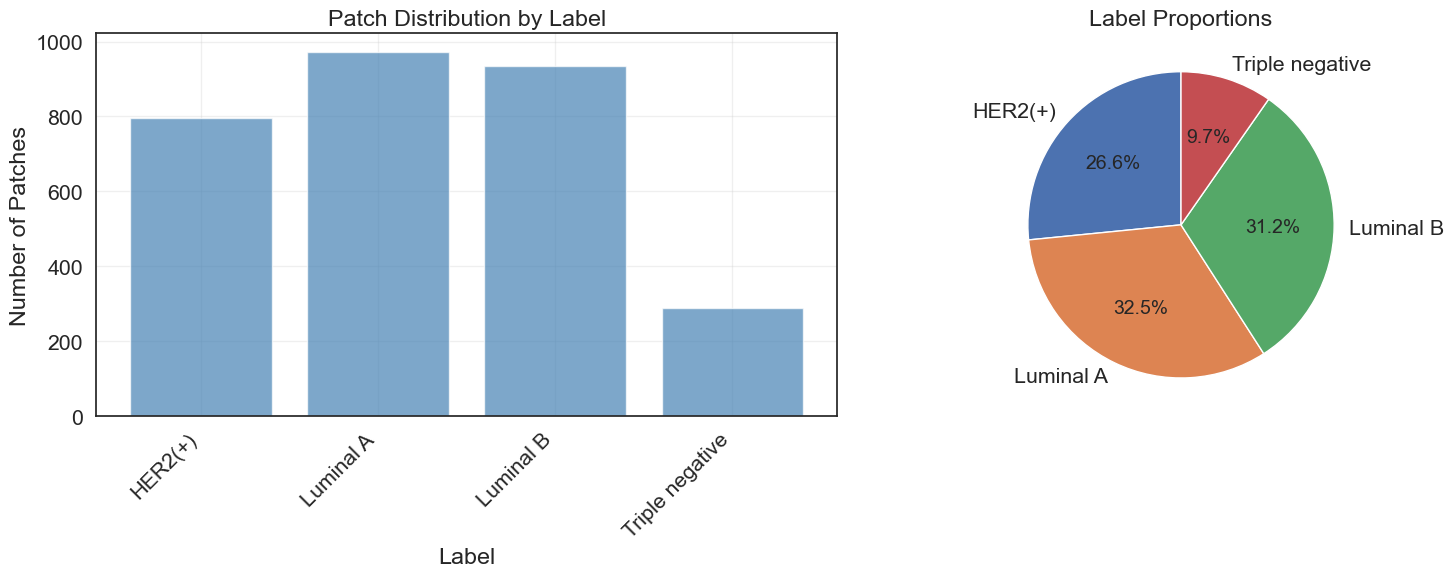

In [25]:
# Create a new CSV file mapping patches to labels based on original image indices
from typing import Counter

print(f"\n{'='*60}")
print(f"Creating Patch-to-Label Mapping CSV")
print(f"{'='*60}")

# Load original labels
original_labels_df = pd.read_csv(CSV_PATH)
print(f"\nOriginal labels CSV contains {len(original_labels_df)} entries")

# Create a mapping dictionary: image_number -> label
# The CSV format is: img_XXXX.jpg, label
image_to_label = {}
for idx, row in original_labels_df.iterrows():
    filename = row.iloc[0]  # e.g., "img_0042.jpg"
    label = row.iloc[1] 
    
    # Extract the image number from filename
    # "img_0042.jpg" -> 42
    img_number = int(filename.split('_')[1].split('.')[0])
    image_to_label[img_number] = label

print(f"Created mapping for {len(image_to_label)} original images")

# Get all patch files from the patched directory
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"Found {len(patch_files)} patch files in {patched_output_dir.name}")

# Create lists to store patch data
patch_data = []
img_numbers = []
labeled_count = 0
unlabeled_count = 0
label_distribution = Counter()

# Process each patch file
for patch_file in tqdm(patch_files, desc="Mapping patches to labels"):
    # Extract original image number from patch filename
    # Format: img_0042_patch03.png
    filename = patch_file.stem  # Remove .png -> "img_0042_patch03"
    parts = filename.split('_')
    
    filename = patch_file.stem  # e.g., "patch_00001_img_0000"
    parts = filename.split('_')

    # Expected format: ['patch', PATCH_IDX, 'img', IMG_IDX]
    if len(parts) == 4 and parts[0] == "patch" and parts[2] == "img":
        try:
            patch_idx = int(parts[1])
            original_img_number = int(parts[3])   # <-- CORRECT EXTRACTION

            if original_img_number in image_to_label:
                label = image_to_label[original_img_number]

                patch_data.append({
                    'filename': patch_file.name,
                    'label': label
                })

                img_numbers.append(original_img_number)

                labeled_count += 1
                label_distribution[label] += 1
            else:
                unlabeled_count += 1

        except ValueError:
            tqdm.write(f"Warning: could not parse numbers in {patch_file.name}")
            unlabeled_count += 1
    else:
        tqdm.write(f"Warning: unexpected filename format: {patch_file.name}")
        unlabeled_count += 1

# Create DataFrame from patch data
patches_df = pd.DataFrame(patch_data)

print(f"\n{'='*60}")
print(f"Mapping Results")
print(f"{'='*60}")
print(f"Successfully labeled patches: {labeled_count}")
print(f"Unlabeled patches: {unlabeled_count}")
print(f"Total patches: {len(patch_files)}")

if labeled_count > 0:
    # Before saving sort the patch data distribution by the original image index
    patches_df = patches_df.sort_values(by='filename')

    # Save to new CSV file
    patches_csv_path = datasets_path / "train_labels_patched.csv"
    patches_df.to_csv(patches_csv_path, index=False)
    print(f"\nSaved patch labels to: {patches_csv_path}")
    
    # Display sample of the CSV
    print(f"\nSample of patched labels CSV:")
    print(patches_df.head(10))
    
    # Show label distribution
    print(f"\n{'='*60}")
    print(f"Label Distribution Across Patches")
    print(f"{'='*60}")
    for label, count in sorted(label_distribution.items()):
        percentage = (count / labeled_count) * 100
        print(f"  {label}: {count} patches ({percentage:.2f}%)")
    
    # Visualize label distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart
    labels_sorted = sorted(label_distribution.keys())
    counts_sorted = [label_distribution[l] for l in labels_sorted]
    
    axes[0].bar(range(len(labels_sorted)), counts_sorted, color='steelblue', alpha=0.7)
    axes[0].set_xticks(range(len(labels_sorted)))
    axes[0].set_xticklabels(labels_sorted, rotation=45, ha='right')
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Number of Patches')
    axes[0].set_title('Patch Distribution by Label')
    axes[0].grid(True, alpha=0.3)
    
    # Pie chart
    axes[1].pie(counts_sorted, labels=labels_sorted, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Label Proportions')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\nError: No patches were successfully labeled!")

### **Splitting the dataset**


Aligning Patched Images with Labels (Split by Original Images)

Loaded 691 original image labels from CSV
Created mapping for 691 original images
Loaded 2992 patch-label mappings

Splitting Original Images (to prevent data leakage)
Number of unique original images with patches: 626
Total patches from these images: 2992

Original image split:
  Training images: 438
  Validation images: 169
  Test images: 19

Assigning Patches to Splits
Found 2992 total patch files


Loading and splitting patches: 100%|██████████| 2992/2992 [00:04<00:00, 644.58it/s]



Split Results
Skipped patches: 0
Total patches loaded: 2992

Label Encoding
Number of unique classes: 4
Classes: [np.str_('HER2(+)'), np.str_('Luminal A'), np.str_('Luminal B'), np.str_('Triple negative')]

Dataset Statistics

Training set:
  Images: (2112, 224, 224, 3)
  Labels: (2112,)
  Patches per original image (avg): 4.82
  Class distribution: [575 651 666 220]

Validation set:
  Images: (798, 224, 224, 3)
  Labels: (798,)
  Patches per original image (avg): 4.72
  Class distribution: [199 299 243  57]

Test set:
  Images: (82, 224, 224, 3)
  Labels: (82,)
  Patches per original image (avg): 4.32
  Class distribution: [21 23 25 13]

Class Distribution Across Splits

HER2(+) (class 0):
  Train: 575 (72.3%)
  Val:   199 (25.0%)
  Test:  21 (2.6%)

Luminal A (class 1):
  Train: 651 (66.9%)
  Val:   299 (30.7%)
  Test:  23 (2.4%)

Luminal B (class 2):
  Train: 666 (71.3%)
  Val:   243 (26.0%)
  Test:  25 (2.7%)

Triple negative (class 3):
  Train: 220 (75.9%)
  Val:   57 (19.7%)
  T

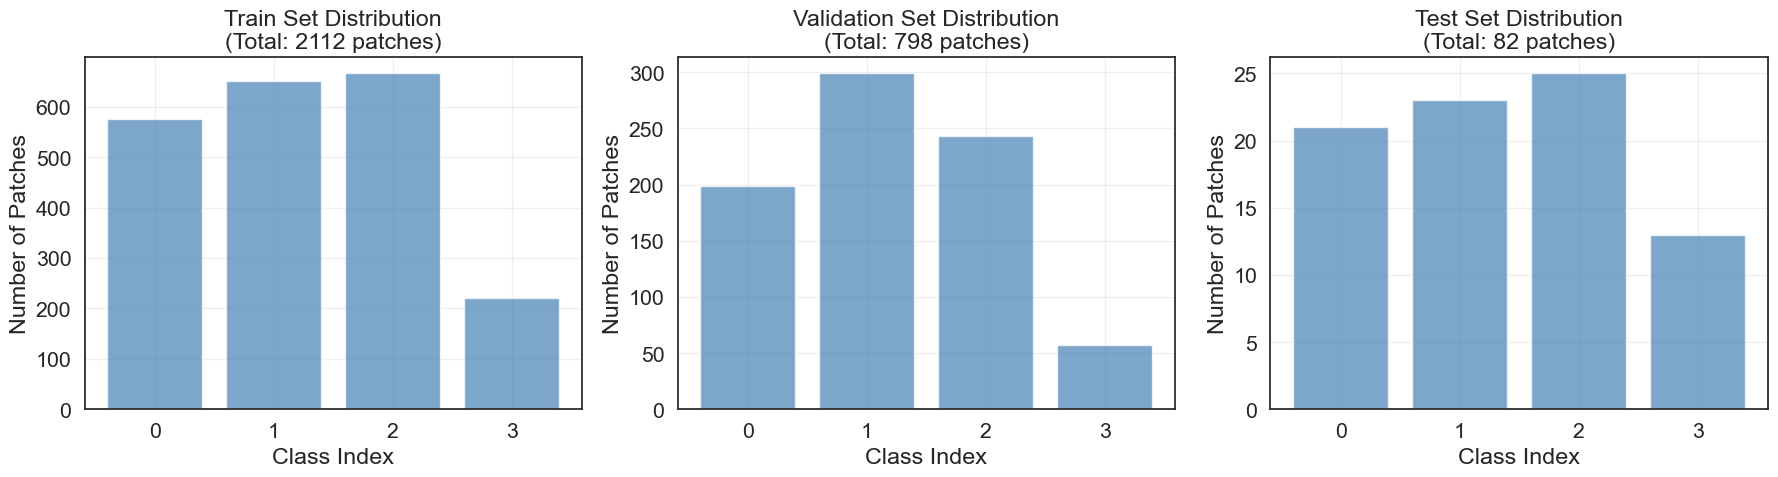


Dataset preparation complete!
No data leakage: Each original image's patches are in only ONE split


In [26]:
from sklearn.preprocessing import LabelEncoder

print(f"\n{'='*60}")
print(f"Aligning Patched Images with Labels (Split by Original Images)")
print(f"{'='*60}")

# Load the ORIGINAL labels CSV (not the patched one)
original_csv_path = datasets_path / "train_labels.csv"
if not original_csv_path.exists():
    raise FileNotFoundError(f"Original labels CSV not found at {original_csv_path}")

original_labels_df = pd.read_csv(original_csv_path)
print(f"\nLoaded {len(original_labels_df)} original image labels from CSV")

# Create mapping: image_number -> label
image_to_label = {}
for idx, row in original_labels_df.iterrows():
    filename = row.iloc[0] 
    label = row.iloc[1]      
    img_number = int(filename.split('_')[1].split('.')[0])
    image_to_label[img_number] = label

print(f"Created mapping for {len(image_to_label)} original images")

# Load the patched labels CSV to get all patches
patches_csv_path = datasets_path / "train_labels_patched.csv"
if not patches_csv_path.exists():
    raise FileNotFoundError(f"Patched labels CSV not found at {patches_csv_path}")

patches_df = pd.read_csv(patches_csv_path)
print(f"Loaded {len(patches_df)} patch-label mappings")

# STEP 1: Split at the ORIGINAL IMAGE LEVEL
print(f"\n{'='*60}")
print(f"Splitting Original Images (to prevent data leakage)")
print(f"{'='*60}")

# Get UNIQUE original image numbers (not duplicates from patches)
unique_img_numbers = sorted(list(set(img_numbers)))
print(f"Number of unique original images with patches: {len(unique_img_numbers)}")
print(f"Total patches from these images: {len(img_numbers)}")

# Get labels for these UNIQUE images
unique_img_labels = [image_to_label[img_num] for img_num in unique_img_numbers]

# Encode labels for stratification
label_encoder = LabelEncoder()
unique_img_labels_encoded = label_encoder.fit_transform(unique_img_labels)

# Split original images into train/temp (70/30)
train_img_nums, temp_img_nums, train_img_labels, temp_img_labels = train_test_split(
    unique_img_numbers,
    unique_img_labels_encoded,
    test_size=0.3,
    random_state=SEED,
    stratify=unique_img_labels_encoded
)

# Split temp into val/test (50/50 of temp = 15/15 of total)
val_img_nums, test_img_nums, val_img_labels, test_img_labels = train_test_split(
    temp_img_nums,
    temp_img_labels,
    test_size=0.1,
    random_state=SEED,
    stratify=temp_img_labels
)

print(f"\nOriginal image split:")
print(f"  Training images: {len(train_img_nums)}")
print(f"  Validation images: {len(val_img_nums)}")
print(f"  Test images: {len(test_img_nums)}")

# STEP 2: Assign patches to splits based on their original image
print(f"\n{'='*60}")
print(f"Assigning Patches to Splits")
print(f"{'='*60}")

train_img_set = set(train_img_nums)
val_img_set = set(val_img_nums)
test_img_set = set(test_img_nums)

# Get all patch files
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"Found {len(patch_files)} total patch files")

# Create a dictionary for fast lookup: filename -> label
patch_to_label = dict(zip(patches_df['filename'], patches_df['label']))

# Separate patches into train/val/test based on original image
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

skipped_count = 0

for patch_file in tqdm(patch_files, desc="Loading and splitting patches"):
    
    patch_filename = patch_file.name

    filename_no_ext = patch_filename.replace(".png", "")
    parts = filename_no_ext.split('_')

    # Expect: ['patch', PATCH_IDX, 'img', IMG_IDX]
    if len(parts) != 4 or parts[0] != "patch" or parts[2] != "img":
        skipped_count += 1
        continue

    try:
        patch_idx = int(parts[1])
        original_img_number = int(parts[3])   # <-- Correct field
    except ValueError:
        skipped_count += 1
        continue

    # Look up the label
    if patch_filename not in patch_to_label:
        skipped_count += 1
        continue
    
    label = patch_to_label[patch_filename]
    
    # Load the patch image
    patch_img = cv2.imread(str(patch_file))
    if patch_img is None:
        tqdm.write(f"Warning: Could not load {patch_filename}")
        skipped_count += 1
        continue
    
    # Convert BGR to RGB and normalize to [0, 1]
    patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB) / 255.0
    
    # Assign to appropriate split based on original image number
    if original_img_number in train_img_set:
        X_train_list.append(patch_rgb)
        y_train_list.append(label)
    elif original_img_number in val_img_set:
        X_val_list.append(patch_rgb)
        y_val_list.append(label)
    elif original_img_number in test_img_set:
        X_test_list.append(patch_rgb)
        y_test_list.append(label)
    else:
        skipped_count += 1

# Convert to numpy arrays
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

print(f"\n{'='*60}")
print(f"Split Results")
print(f"{'='*60}")
print(f"Skipped patches: {skipped_count}")
print(f"Total patches loaded: {len(X_train) + len(X_val) + len(X_test)}")

# Encode labels
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Print class mapping
print(f"\n{'='*60}")
print(f"Label Encoding")
print(f"{'='*60}")
print(f"Number of unique classes: {len(label_encoder.classes_)}")
print(f"Classes: {list(label_encoder.classes_)}")

# Show split statistics
print(f"\n{'='*60}")
print(f"Dataset Statistics")
print(f"{'='*60}")

print(f"\nTraining set:")
print(f"  Images: {X_train.shape}")
print(f"  Labels: {y_train_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_train) / len(train_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_train_encoded)}")

print(f"\nValidation set:")
print(f"  Images: {X_val.shape}")
print(f"  Labels: {y_val_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_val) / len(val_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_val_encoded)}")

print(f"\nTest set:")
print(f"  Images: {X_test.shape}")
print(f"  Labels: {y_test_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_test) / len(test_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_test_encoded)}")

# Show label distribution across splits
unique_train, counts_train = np.unique(y_train_encoded, return_counts=True)
unique_val, counts_val = np.unique(y_val_encoded, return_counts=True)
unique_test, counts_test = np.unique(y_test_encoded, return_counts=True)

train_counts_map = dict(zip(unique_train, counts_train))
val_counts_map = dict(zip(unique_val, counts_val))
test_counts_map = dict(zip(unique_test, counts_test))

print(f"\n{'='*60}")
print(f"Class Distribution Across Splits")
print(f"{'='*60}")
for class_idx in range(len(label_encoder.classes_)):
    class_name = label_encoder.classes_[class_idx]
    train_count = int(train_counts_map.get(class_idx, 0))
    val_count = int(val_counts_map.get(class_idx, 0))
    test_count = int(test_counts_map.get(class_idx, 0))
    total = train_count + val_count + test_count

    if total == 0:
        train_pct = val_pct = test_pct = 0.0
    else:
        train_pct = train_count / total * 100
        val_pct = val_count / total * 100
        test_pct = test_count / total * 100
    
    print(f"\n{class_name} (class {class_idx}):")
    print(f"  Train: {train_count} ({train_pct:.1f}%)")
    print(f"  Val:   {val_count} ({val_pct:.1f}%)")
    print(f"  Test:  {test_count} ({test_pct:.1f}%)")

# Visualize split distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, split_labels) in enumerate([
    ('Train', y_train_encoded), 
    ('Validation', y_val_encoded), 
    ('Test', y_test_encoded)
]):
    class_counts = np.bincount(split_labels)
    axes[idx].bar(range(len(class_counts)), class_counts, color='steelblue', alpha=0.7)
    axes[idx].set_xlabel('Class Index')
    axes[idx].set_ylabel('Number of Patches')
    axes[idx].set_title(f'{split_name} Set Distribution\n(Total: {len(split_labels)} patches)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Update the global variables to use encoded labels
y_train = y_train_encoded
y_val = y_val_encoded
y_test = y_test_encoded

print(f"\n{'='*60}")
print(f"Dataset preparation complete!")
print(f"No data leakage: Each original image's patches are in only ONE split")
print(f"{'='*60}")

In [27]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


In [28]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds = TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2),
    torch.from_numpy(y_train).squeeze().long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2),
    torch.from_numpy(y_val).squeeze().long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2),
    torch.from_numpy(y_test).squeeze().long()
)

In [29]:
# Define the batch size
BATCH_SIZE = 32

In [40]:
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class TissueDataset(torch.utils.data.Dataset):
    """Custom PyTorch Dataset with augmentation and normalization."""

    def __init__(self, data, labels, augmentation=None, normalize_imagenet=False):
        """
        Args:
            data: numpy array of images (N, H, W, C) in range [0, 1]
            labels: numpy array of labels
            augmentation: transforms for data augmentation
            normalize_imagenet: whether to apply ImageNet normalization
        """
        # Convert from (N, H, W, C) to (N, C, H, W) for PyTorch
        # IMPORTANT: Use .float() to ensure float32 type (compatible with mixed precision)
        self.data = torch.from_numpy(data).permute(0, 3, 1, 2).float()
        self.labels = torch.from_numpy(labels).long()
        self.augmentation = augmentation
        self.normalize_imagenet = normalize_imagenet

        # ImageNet normalization transform
        if normalize_imagenet:
            self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        else:
            self.normalize = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].clone()  # Clone to avoid modifying original (already in C, H, W format)
        label = self.labels[idx]

        # Apply augmentation if provided (on images in [0, 1] range)
        if self.augmentation:
            image = self.augmentation(image)
            # CRITICAL FIX: Clip values back to [0, 1] after augmentation
            # TrivialAugmentWide and other augmentations can push values outside [0, 1]
            image = torch.clamp(image, -1.0, 1.0)

        # Apply ImageNet normalization if requested
        if self.normalize:
            image = self.normalize(image)

        return image, label

In [32]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Use 0 workers on Windows to avoid multiprocessing issues
    # Single-threaded loading is more stable on Windows
    num_workers = 0

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
    )

### Network parameters

In [33]:
# Training parameters
# FIXED: Reduced learning rate for better convergence from scratch
LEARNING_RATE = 1e-4  # Changed from 3e-4 (too high for from-scratch training)
EPOCHS = 200
PATIENCE = 50

# Regularization
# FIXED: Reduced dropout for early training
DROPOUT_RATE = 0.2  # Changed from 0.3 (less aggressive)
L2_REGULARIZATION = 1e-4  # Reduced from 1e-3

from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
weight_tensor = torch.tensor(weights, dtype=torch.float32, device=device)

# class FocalLoss(nn.Module):
#     def __init__(self, weight=None, gamma=2.0, reduction='mean'):
#         super().__init__()
#         self.weight = weight
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         ce_loss = nn.functional.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
#         pt = torch.exp(-ce_loss)
#         focal_loss = (1 - pt) ** self.gamma * ce_loss
#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         if self.reduction == 'sum':
#             return focal_loss.sum()
#         return focal_loss

# criterion = FocalLoss(weight=weight_tensor, gamma=2.0)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

# Print the defined parameters
print(" UPDATED TRAINING PARAMETERS:")
print("="*60)
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE, "← Reduced for better convergence")
print("Dropout Rate:", DROPOUT_RATE, "← Less aggressive")
print("L2 Regularization:", L2_REGULARIZATION, "← Reduced")
print("Patience:", PATIENCE)
print("="*60)

 UPDATED TRAINING PARAMETERS:
Epochs: 200
Batch Size: 32
Learning Rate: 0.0001 ← Reduced for better convergence
Dropout Rate: 0.2 ← Less aggressive
L2 Regularization: 0.0001 ← Reduced
Patience: 50


## Training functions

In [34]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [35]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        use_amp = device.type == 'cuda' and scaler is not None
        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling (only if scaler is provided)
        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    all_targets_concat = np.concatenate(all_targets)
    all_predictions_concat = np.concatenate(all_predictions)
    
    epoch_f1 = f1_score(all_targets_concat, all_predictions_concat, average='weighted')
    epoch_precision = precision_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)

    return epoch_loss, epoch_f1, epoch_precision, epoch_recall

In [36]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    all_targets_concat = np.concatenate(all_targets)
    all_predictions_concat = np.concatenate(all_predictions)
    
    epoch_f1 = f1_score(all_targets_concat, all_predictions_concat, average='weighted')
    epoch_precision = precision_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)

    return epoch_loss, epoch_f1, epoch_precision, epoch_recall

In [37]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", scheduler=None):
    """
    Train the neural network model on the training data and validate on the validation data.

# NOTE: Graphviz visualization commented out - requires Graphviz installation



# model_graph.visual_graph# model_graph = draw_graph(scratch_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)# After installing Graphviz, restart kernel and uncomment these lines:        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_f1, train_precision, train_recall = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        val_loss, val_f1, val_precision, val_recall = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_f1)  # For backward compatibility
        training_history['val_acc'].append(val_f1)  # For backward compatibility
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)
        training_history['train_precision'].append(train_precision)
        training_history['val_precision'].append(val_precision)
        training_history['train_recall'].append(train_recall)
        training_history['val_recall'].append(val_recall)

        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('F1/Training', train_f1, epoch)
            writer.add_scalar('F1/Validation', val_f1, epoch)
            writer.add_scalar('Precision/Training', train_precision, epoch)
            writer.add_scalar('Precision/Validation', val_precision, epoch)
            writer.add_scalar('Recall/Training', train_recall, epoch)
            writer.add_scalar('Recall/Validation', val_recall, epoch)

        if verbose and epoch % verbose == 0:
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f}, Prec={train_precision:.4f}, Rec={train_recall:.4f} | "
                  f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}, Prec={val_precision:.4f}, Rec={val_recall:.4f}")

        # Learning rate scheduling
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_f1)  # Step based on validation F1
            else:
                scheduler.step()  # For other schedulers

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                model_path = f"models/{experiment_name}_best_model.pt"
                torch.save(model.state_dict(), model_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break
                    
    if restore_best_weights and patience > 0:
        model_path = f"models/{experiment_name}_best_model.pt"
        model.load_state_dict(torch.load(model_path))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
    return model, training_history

###  🛠️ **Train from Scratch**

In [18]:
# Improved ResNet architecture with better classifier head
class ResNetFromScratch(nn.Module):
    """ResNet trained from scratch with improved classifier head."""

    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()

        # Use ResNet18 but replace first conv to reduce parameters
        self.backbone = torchvision.models.resnet18(weights=None)
        
        # Remove the original fc layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Simpler classifier head (fewer layers, fewer neurons)
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 256),  # 512 -> 256
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)  # Direct to output (removed intermediate layer)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

In [93]:
# Initialize model
scratch_model = ResNetFromScratch(num_classes, DROPOUT_RATE).to(device)

# Visualize structure
summary(scratch_model, input_size=input_shape)
# model_graph = draw_graph(scratch_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [94]:
# Print total parameters
total_params = sum(p.numel() for p in scratch_model.parameters())
trainable_params = sum(p.numel() for p in scratch_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 11,309,380
Trainable parameters: 11,309,380


### Augmentation

In [38]:
# ============================================================
# AUGMENTATION STRATEGY COMPARISON
# ============================================================

# Strategy 1: Manual Augmentation (Your current approach)
train_augmentation_manual = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(
        degrees=0, 
        scale=None,
        shear=10
    ),
    # Color/appearance transformations
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
])

# Strategy 2: TrivialAugmentWide (State-of-the-art, zero hyperparameters)
# Recommended for best performance with no tuning needed
train_augmentation_trivial = transforms.Compose([
    transforms.TrivialAugmentWide(),  # Applies one random augmentation per image
    # Optional: Add task-specific augmentations
    transforms.RandomHorizontalFlip(p=0.5),
])

# Strategy 3: RandAugment (Customizable strength)
# num_ops: Number of augmentation operations to apply per image (1-3 recommended)
# magnitude: Strength of augmentations (0-30, higher = stronger)
train_augmentation_rand = transforms.Compose([
    transforms.RandAugment(num_ops=2, magnitude=9),  # Apply 2 random ops with magnitude 9
    transforms.RandomHorizontalFlip(p=0.5),
])

# Strategy 4: AutoAugment (Optimized for ImageNet)
# Best for transfer learning with ImageNet-pretrained models
# Also works for from-scratch training thanks to the clamp fix in TissueDataset
train_augmentation_auto = transforms.Compose([
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(p=0.5),
])

# ============================================================
# SELECT YOUR AUGMENTATION STRATEGY
# ============================================================

# ✅ AutoAugment selected - Now SAFE to use thanks to torch.clamp() fix in TissueDataset!
# The clamp prevents values from going outside [0, 1] range
train_augmentation = train_augmentation_auto      # ✓ AutoAugment (ImageNet policy)
# train_augmentation = train_augmentation_trivial  # ✓ TrivialAugmentWide (state-of-the-art)
# train_augmentation = train_augmentation_rand      # ✓ RandAugment (customizable)
# train_augmentation = train_augmentation_manual    # ✓ Manual augmentation

print(f" Selected augmentation strategy: {train_augmentation.transforms[0].__class__.__name__}")
print(f"\nAugmentation pipeline:")
for idx, transform in enumerate(train_augmentation.transforms):
    print(f"  {idx+1}. {transform.__class__.__name__}")
    if hasattr(transform, 'num_ops'):
        print(f"     - num_ops: {transform.num_ops}, magnitude: {transform.magnitude}")
    elif hasattr(transform, 'p'):
        print(f"     - probability: {transform.p}")

print(f"\n⚠️  NOTE: AutoAugment can push pixel values outside [0,1]")
print(f"    ✅ But TissueDataset now includes torch.clamp(0,1) to fix this!")

 Selected augmentation strategy: AutoAugment

Augmentation pipeline:
  1. AutoAugment
  2. RandomHorizontalFlip
     - probability: 0.5

⚠️  NOTE: AutoAugment can push pixel values outside [0,1]
    ✅ But TissueDataset now includes torch.clamp(0,1) to fix this!


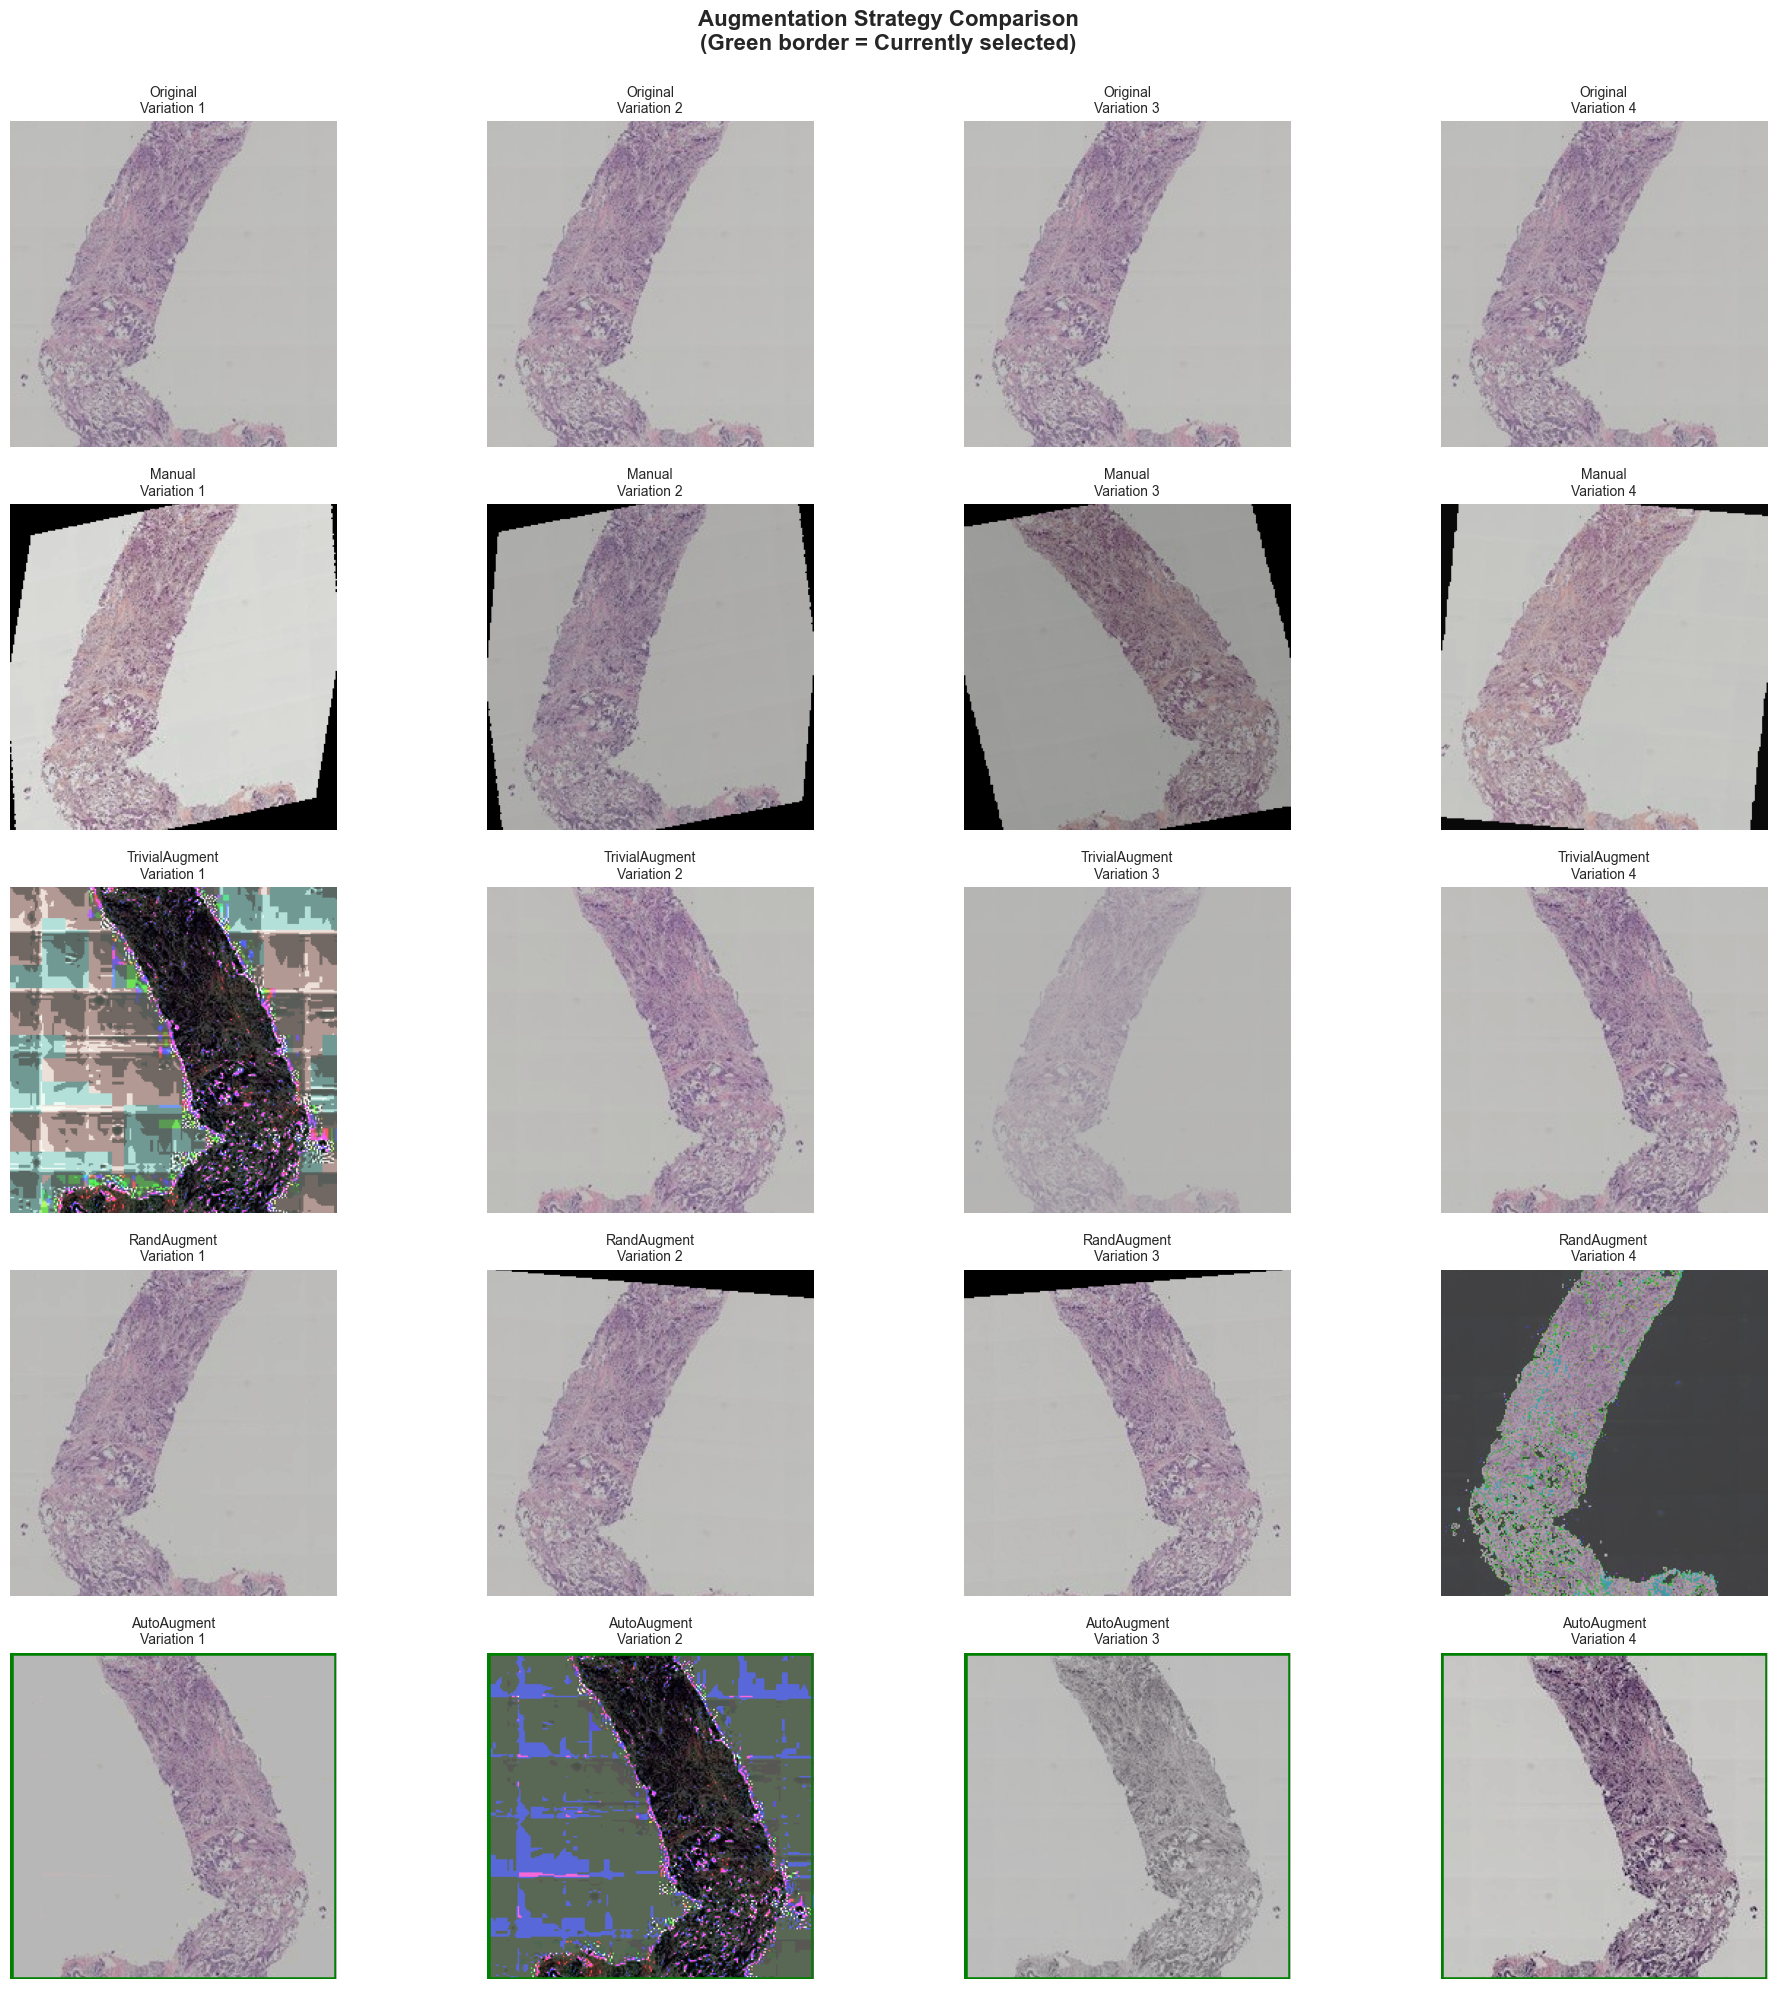


Showing diversity of selected augmentation: AutoAugment


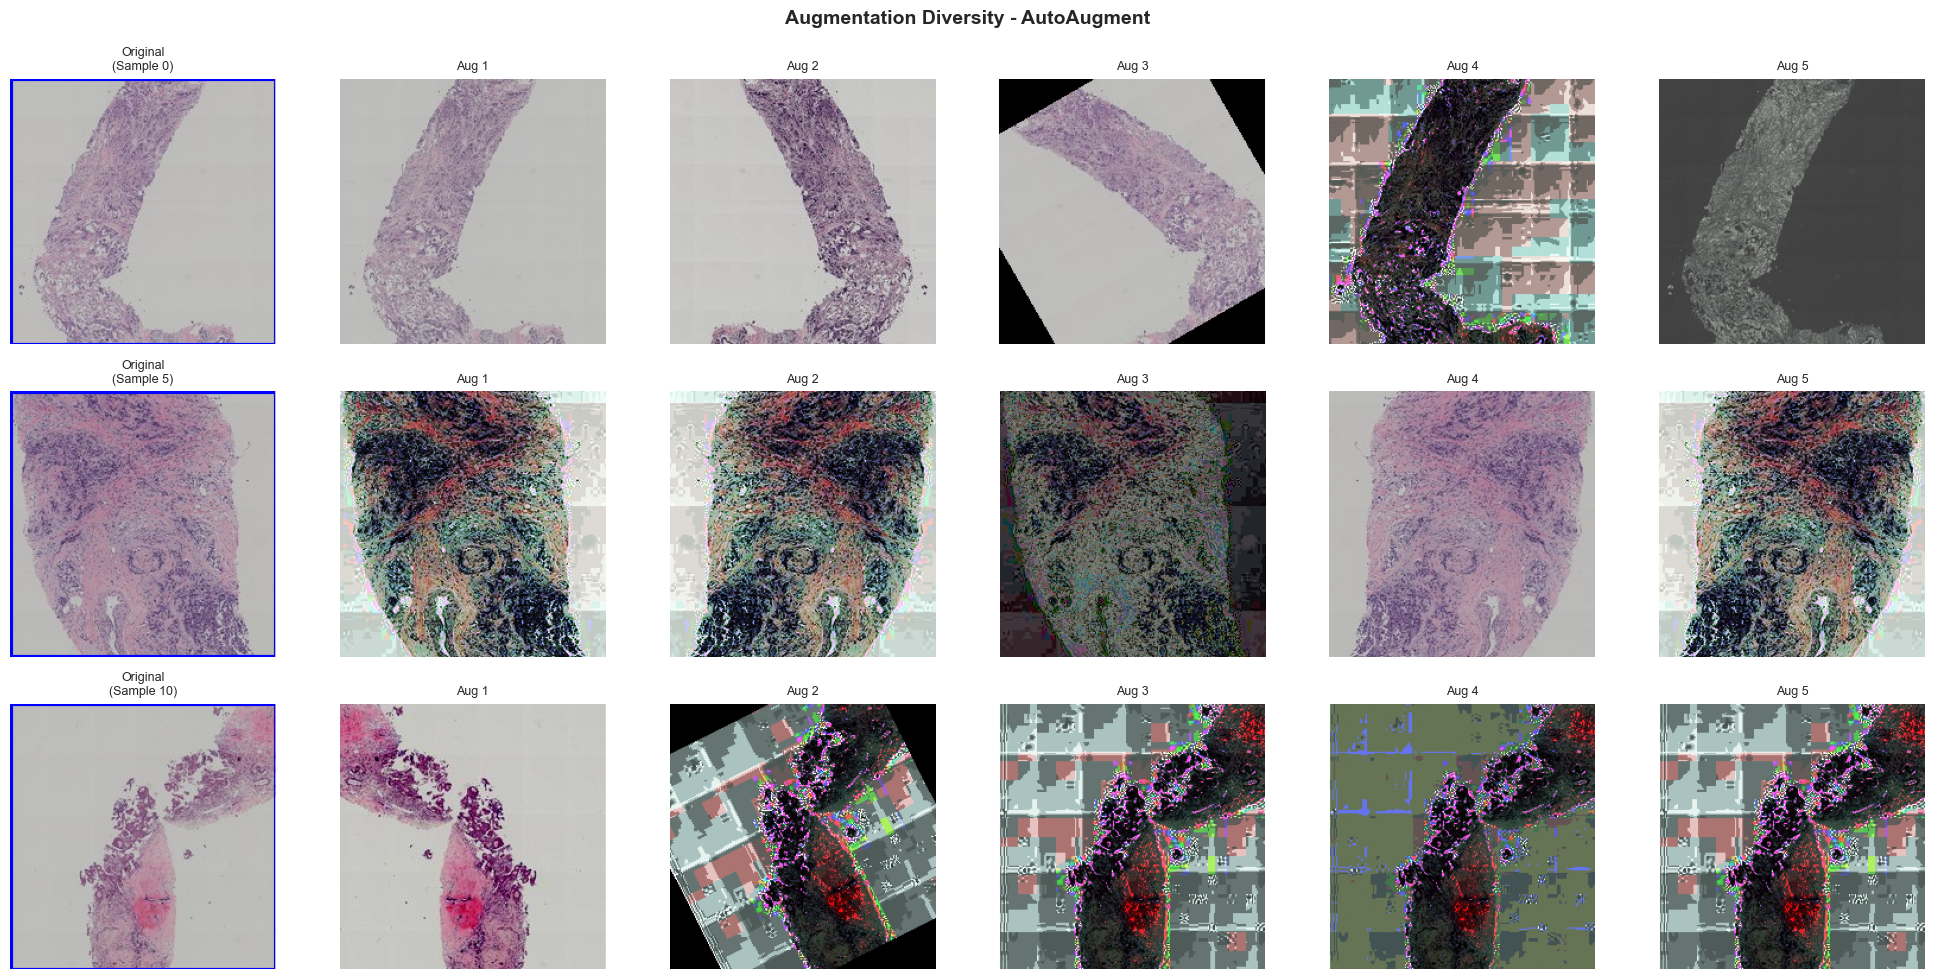


Augmentation Strategy Recommendations:
✓ TrivialAugmentWide: Best for general use (no tuning needed)
  - State-of-the-art performance
  - Applies one random augmentation per image
  - No hyperparameters to tune

✓ RandAugment: Good for customization
  - Control strength with 'magnitude' (0-30)
  - Control diversity with 'num_ops' (1-3)
  - Good for fine-tuning to your specific dataset

✓ AutoAugment: Best for ImageNet transfer learning
  - Pre-optimized for ImageNet statistics
  - Use when fine-tuning pretrained models (EfficientNet, ResNet)

✓ Manual: Best for domain-specific needs
  - Full control over each transformation
  - Use when you have specific domain knowledge


In [39]:
# ============================================================
# VISUALIZE AUTOMATED AUGMENTATION EFFECTS
# ============================================================

# Compare all augmentation strategies side-by-side
sample_idx = 0
sample_img = X_train[sample_idx]
sample_tensor = torch.from_numpy(sample_img).permute(2, 0, 1)  # Convert to C,H,W

# Define all strategies for comparison
strategies = {
    'Original': None,
    'Manual': train_augmentation_manual,
    'TrivialAugment': train_augmentation_trivial,
    'RandAugment': train_augmentation_rand,
    'AutoAugment': train_augmentation_auto,
}

# Show 4 variations of each strategy
num_variations = 4
fig, axes = plt.subplots(len(strategies), num_variations, figsize=(20, 4 * len(strategies)))

for row, (strategy_name, augmentation) in enumerate(strategies.items()):
    for col in range(num_variations):
        if augmentation is None:
            # Show original
            display_img = sample_img
        else:
            # Apply augmentation
            aug_tensor = augmentation(sample_tensor.clone())
            display_img = aug_tensor.permute(1, 2, 0).numpy()
        
        axes[row, col].imshow(np.clip(display_img, 0, 1))
        axes[row, col].set_title(f"{strategy_name}\nVariation {col+1}", fontsize=10)
        axes[row, col].axis('off')
        
        # Highlight the selected strategy
        if augmentation == train_augmentation:
            axes[row, col].add_patch(plt.Rectangle(
                (0, 0), display_img.shape[1], display_img.shape[0],
                fill=False, edgecolor='green', linewidth=4
            ))

plt.suptitle("Augmentation Strategy Comparison\n(Green border = Currently selected)", 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Show diversity: Multiple samples with selected augmentation
print(f"\nShowing diversity of selected augmentation: {train_augmentation.transforms[0].__class__.__name__}")
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for row in range(3):
    sample_idx = row * 5
    sample_img = X_train[sample_idx]
    sample_tensor = torch.from_numpy(sample_img).permute(2, 0, 1)
    
    # Original
    axes[row, 0].imshow(np.clip(sample_img, 0, 1))
    axes[row, 0].set_title(f"Original\n(Sample {sample_idx})", fontsize=9)
    axes[row, 0].axis('off')
    axes[row, 0].add_patch(plt.Rectangle(
        (0, 0), sample_img.shape[1], sample_img.shape[0],
        fill=False, edgecolor='blue', linewidth=3
    ))
    
    # 5 augmented versions
    for col in range(1, 6):
        aug_tensor = train_augmentation(sample_tensor.clone())
        aug_img = aug_tensor.permute(1, 2, 0).numpy()
        axes[row, col].imshow(np.clip(aug_img, 0, 1))
        axes[row, col].set_title(f"Aug {col}", fontsize=9)
        axes[row, col].axis('off')

plt.suptitle(f"Augmentation Diversity - {train_augmentation.transforms[0].__class__.__name__}", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Augmentation Strategy Recommendations:")
print(f"{'='*60}")
print("✓ TrivialAugmentWide: Best for general use (no tuning needed)")
print("  - State-of-the-art performance")
print("  - Applies one random augmentation per image")
print("  - No hyperparameters to tune")
print()
print("✓ RandAugment: Good for customization")
print("  - Control strength with 'magnitude' (0-30)")
print("  - Control diversity with 'num_ops' (1-3)")
print("  - Good for fine-tuning to your specific dataset")
print()
print("✓ AutoAugment: Best for ImageNet transfer learning")
print("  - Pre-optimized for ImageNet statistics")
print("  - Use when fine-tuning pretrained models (EfficientNet, ResNet)")
print()
print("✓ Manual: Best for domain-specific needs")
print("  - Full control over each transformation")
print("  - Use when you have specific domain knowledge")
print(f"{'='*60}")

In [ ]:
# ============================================================
# CREATE DATASETS WITH APPROPRIATE AUGMENTATION
# ============================================================

# For FROM SCRATCH model: Use TrivialAugmentWide (strongest augmentation)
# train_augmentation_scratch = transforms.Compose([
#     transforms.TrivialAugmentWide(),
#     transforms.RandomHorizontalFlip(p=0.5),
# ])

print("="*60)
print("FROM SCRATCH MODEL - Augmentation Strategy")
print("="*60)
print("Using: TrivialAugmentWide + RandomHorizontalFlip")
print("Rationale: Strong augmentation to prevent overfitting when training from scratch")
print()

# Create datasets with strong augmentation for from-scratch training
train_scratch_ds = TissueDataset(X_train, y_train, augmentation=train_augmentation, normalize_imagenet=False)
val_scratch_ds = TissueDataset(X_val, y_val, augmentation=None, normalize_imagenet=False)

train_scratch_loader = make_loader(train_scratch_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_scratch_loader = make_loader(val_scratch_ds, BATCH_SIZE, shuffle=False, drop_last=False)

# Check a sample batch
sample_batch, sample_labels = next(iter(train_scratch_loader))

# Validate data before training
print("Dataset Validation:")
print(f"  Train samples: {len(train_scratch_ds)}")
print(f"  Val samples: {len(val_scratch_ds)}")
print(f"  Batch shape: {sample_batch.shape}")
print(f"  Batch value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
print(f"  Labels in batch: {sample_labels[:10].tolist()}")
print(f"  Number of classes: {num_classes}")
print(f"  Class distribution: {np.bincount(y_train)}")
print()

# Show augmentation samples
print("Sample augmentations applied:")
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
sample_img = X_train[0]
sample_tensor = torch.from_numpy(sample_img).permute(2, 0, 1)

for i in range(10):
    row = i // 5
    col = i % 5
    
    if i == 0:
        display_img = sample_img
        title = "Original"
        color = 'blue'
    else:
        aug_tensor = train_augmentation_scratch(sample_tensor.clone())
        display_img = aug_tensor.permute(1, 2, 0).numpy()
        title = f"Augmented {i}"
        color = 'green'
    
    axes[row, col].imshow(np.clip(display_img, 0, 1))
    axes[row, col].set_title(title, fontsize=10, color=color, fontweight='bold')
    axes[row, col].axis('off')
    
    if i == 0:
        axes[row, col].add_patch(plt.Rectangle(
            (0, 0), display_img.shape[1], display_img.shape[0],
            fill=False, edgecolor=color, linewidth=3
        ))

plt.suptitle("TrivialAugmentWide - Strong Augmentation for From-Scratch Training", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [98]:
# Training Setup: Optimizer and Scheduler
scratch_model = ResNetFromScratch(num_classes, DROPOUT_RATE).to(device)

# Use AdamW instead of RAdam for better convergence
optimizer = torch.optim.AdamW(
    scratch_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=L2_REGULARIZATION,  # Built-in L2 regularization
    betas=(0.9, 0.999)
)

# Add Cosine Annealing for better learning rate schedule
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=EPOCHS, 
    eta_min=1e-6
)

# Mixed precision scaler
scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None

# TensorBoard writer
experiment_name = "from_scratch_FIXED"
writer = SummaryWriter(log_dir=f'tensorboard/{experiment_name}')

print("FIXED TRAINING SETUP:")
print("="*60)
print(f"  Optimizer: AdamW (better than RAdam for this case)")
print(f"  Scheduler: CosineAnnealingLR")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Model: ResNet18 from scratch")
print(f"  Dropout: {DROPOUT_RATE}")
print("="*60)

FIXED TRAINING SETUP:
  Optimizer: AdamW (better than RAdam for this case)
  Scheduler: CosineAnnealingLR
  Learning Rate: 0.0001
  Model: ResNet18 from scratch
  Dropout: 0.2


In [99]:
# PRE-TRAINING DIAGNOSTICS
print("\n" + "="*60)
print("PRE-TRAINING DIAGNOSTICS")
print("="*60)

# Check class distribution
print("\n1. Class Distribution Check:")
class_counts = np.bincount(y_train)
print(f"   Number of classes: {num_classes}")
print(f"   Class counts: {class_counts}")
print(f"   Class balance ratio: {class_counts.max() / class_counts.min():.2f}x")
if class_counts.max() / class_counts.min() > 10:
    print(" WARNING: Severe class imbalance detected!")
else:
    print(" Class balance is reasonable")

# Check data range
sample_batch, sample_labels = next(iter(train_scratch_loader))
print(f"\n2. Data Range Check:")
print(f"   Batch shape: {sample_batch.shape}")
print(f"   Data range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
print(f"   Data mean: {sample_batch.mean():.3f}")
print(f"   Data std: {sample_batch.std():.3f}")
if sample_batch.min() < -1 or sample_batch.max() > 2:
    print("   WARNING: Data range looks abnormal!")
else:
    print("   Data range looks good")

# Check model output
scratch_model.eval()
with torch.no_grad():
    test_output = scratch_model(sample_batch[:2].to(device))
    print(f"\n3. Model Output Check:")
    print(f"   Output shape: {test_output.shape}")
    print(f"   Output range: [{test_output.min():.3f}, {test_output.max():.3f}]")
    print(f"   Softmax probs (first sample): {torch.softmax(test_output[0], dim=0).cpu().numpy()}")
    
    # Check if model is making reasonable predictions
    probs = torch.softmax(test_output, dim=1)
    max_probs = probs.max(dim=1)[0]
    print(f"   Max probability: {max_probs.mean():.3f}")
    if max_probs.mean() < 0.2:
        print("   WARNING: Model has very low confidence (might not be learning)")
    else:
        print("   Model confidence looks reasonable")

scratch_model.train()

print("\n" + "="*60)


PRE-TRAINING DIAGNOSTICS

1. Class Distribution Check:
   Number of classes: 4
   Class counts: [264 285 306 107]
   Class balance ratio: 2.86x
 Class balance is reasonable

2. Data Range Check:
   Batch shape: torch.Size([32, 3, 224, 224])
   Data range: [0.000, 1.000]
   Data mean: 0.524
   Data std: 0.235
   Data range looks good

3. Model Output Check:
   Output shape: torch.Size([2, 4])
   Output range: [-0.314, 0.050]
   Softmax probs (first sample): [0.29438403 0.23346622 0.26751876 0.204631  ]
   Max probability: 0.292
   Model confidence looks reasonable



In [ ]:
# FIXED: Train improved model with all fixes applied
print("\n" + "="*60)
print("STARTING TRAINING WITH FIXES")
print("="*60)
print("Key Changes:")
print("  1. TrivialAugmentWide (instead of AutoAugment)")
print("  2. Lower learning rate (1e-4 instead of 3e-4)")
print("  3. Lower dropout (0.2 instead of 0.3)")
print("  4. AdamW optimizer with CosineAnnealingLR")
print("  5. Removed L2 regularization lambda conflict")
print("  6. Disabled mixed precision training (set scaler=None)")
print("="*60 + "\n")

scratch_model, scratch_history = fit(
    model=scratch_model,
    train_loader=train_scratch_loader,
    val_loader=val_scratch_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=None,  
    device=device,
    l2_lambda=0,  
    writer=writer,
    scheduler=scheduler,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_f1 = round(max(scratch_history['val_f1']) * 100, 2)
final_train_f1 = round(max(scratch_history['train_f1']) * 100, 2)
print(f'\n{"="*60}')
print(f'Training Complete!')
print(f'Best Training F1: {final_train_f1}%')
print(f'Best Validation F1: {final_val_f1}%')
print(f'{"="*60}')

In [ ]:
# ✅ VERIFY THE FIX: Re-create dataloaders with fixed TissueDataset
print("="*60)
print("RECREATING DATALOADERS WITH FIXED TissueDataset")
print("="*60)

# Recreate datasets with the FIXED TissueDataset class
train_scratch_ds = TissueDataset(X_train, y_train, augmentation=train_augmentation, normalize_imagenet=False)
val_scratch_ds = TissueDataset(X_val, y_val, augmentation=None, normalize_imagenet=False)

train_scratch_loader = make_loader(train_scratch_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_scratch_loader = make_loader(val_scratch_ds, BATCH_SIZE, shuffle=False, drop_last=False)

# Test the fix
sample_batch_fixed, sample_labels_fixed = next(iter(train_scratch_loader))

print(f"\n✅ VERIFICATION:")
print(f"   Batch shape: {sample_batch_fixed.shape}")
print(f"   Data range: [{sample_batch_fixed.min():.3f}, {sample_batch_fixed.max():.3f}]")
print(f"   Data mean: {sample_batch_fixed.mean():.3f}")
print(f"   Data std: {sample_batch_fixed.std():.3f}")

if sample_batch_fixed.min() >= 0.0 and sample_batch_fixed.max() <= 1.0:
    print("\n   ✅ SUCCESS! Data is now properly clipped to [0, 1]")
    print("   You can now retrain the model with much better results!")
else:
    print("\n   ❌ Still seeing issues. Check the TissueDataset implementation.")

print("="*60)

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(scratch_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(scratch_history['val_loss'], label='Validation loss', alpha=0.9, color="#ff7e0e")
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(scratch_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(scratch_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#ff7f0e')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [ ]:
# Enhanced training history visualization with all metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Loss plot
axes[0, 0].plot(scratch_history['train_loss'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[0, 0].plot(scratch_history['val_loss'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[0, 0].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# F1 Score plot
axes[0, 1].plot(scratch_history['train_f1'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[0, 1].plot(scratch_history['val_f1'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[0, 1].set_title('F1 Score over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision plot
axes[1, 0].plot(scratch_history['train_precision'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[1, 0].plot(scratch_history['val_precision'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[1, 0].set_title('Precision over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall plot
axes[1, 1].plot(scratch_history['train_recall'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[1, 1].plot(scratch_history['val_recall'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[1, 1].set_title('Recall over Epochs', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("Training Summary:")
print("="*60)
print(f"Best Training   - Loss: {min(scratch_history['train_loss']):.4f}, F1: {max(scratch_history['train_f1']):.4f}, "
      f"Prec: {max(scratch_history['train_precision']):.4f}, Rec: {max(scratch_history['train_recall']):.4f}")
print(f"Best Validation - Loss: {min(scratch_history['val_loss']):.4f}, F1: {max(scratch_history['val_f1']):.4f}, "
      f"Prec: {max(scratch_history['val_precision']):.4f}, Rec: {max(scratch_history['val_recall']):.4f}")
print("="*60)

In [ ]:
# Make predictions on the test set created inside the training set
test_scratch_ds = TissueDataset(X_test, y_test, augmentation=None, normalize_imagenet=False)
test_scratch_loader = make_loader(test_scratch_ds, BATCH_SIZE, shuffle=False, drop_last=False)

best_val_acc = max(scratch_history['val_acc'])
model_path = Path(f"models/{experiment_name}_{best_val_acc:.4f}_model.pt")
if not model_path.exists():
    candidates = sorted(Path("models").glob(f"{experiment_name}_*_model.pt"))
    if candidates:
        model_path = candidates[-1]
    else:
        raise FileNotFoundError(f"No model file matching {model_path.name}")
scratch_model.load_state_dict(torch.load(model_path, map_location=device))
scratch_model.eval()
print(f"Loaded weights from {model_path.name}")

all_test_predictions = []
with torch.no_grad():
    for inputs, _ in test_scratch_loader:
        inputs = inputs.to(device)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = scratch_model(inputs)
        predictions = logits.argmax(dim=1)
        all_test_predictions.append(predictions.cpu().numpy())
all_test_predictions = np.concatenate(all_test_predictions)

# Calculate test metrics
test_f1 = f1_score(y_test, all_test_predictions, average='weighted')
test_precision = precision_score(y_test, all_test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(y_test, all_test_predictions, average='weighted', zero_division=0)
print(f"\nTest Set Performance:")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

## 🛠️ **Transfer Learining**

In [42]:
# MobileNetv3 small
class MobileNetV3Small(nn.Module):
    """MobileNetV3 Small architecture for image classification."""

    def __init__(self, num_classes, dropout_rate=0.2, freeze_backbone=True):
        super().__init__()

        # Load MobileNetV3 Small with pretrained weights
        self.backbone = torchvision.models.mobilenet_v3_small(
            weights=torchvision.models.MobileNet_V3_Small_Weights.DEFAULT
        )
             # Freeze the backbone layers (features)
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False
        # MobileNetV3 classifier structure is different:
        # classifier[0] is Linear(576 -> 1024)
        # classifier[1] is Hardswish
        # classifier[2] is Dropout
        # classifier[3] is Linear(1024 -> num_classes)

        # Get the correct input features from the last conv layer
        # For MobileNetV3-Small, the last feature size is 576
        in_features = 576  # This is the output from the last conv block


        # Replace the entire classifier head
        #self.backbone.classifier = nn.Sequential(
        #    nn.Linear(in_features, 1024),  # Match original architecture
        #    nn.Hardswish(inplace=True),
        #    nn.Dropout(p=dropout_rate),
        #    nn.Linear(1024, 256),
        #    nn.ReLU(inplace=True),
        #    nn.Dropout(p=dropout_rate),
        #    nn.Linear(256, num_classes)
        #)
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 512),  # Match original architecture
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(64, num_classes)
            # nn.Linear(512, num_classes)  # Added just this final layer for simplifying the architecture
        )


    def forward(self, x):
        return self.backbone(x)

In [47]:
class EfficientNetB3TransferLearning(nn.Module):
    """EfficientNet-B3 with ImageNet pretrained weights."""

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        # Load weights pretrained on ImageNet
        self.backbone = torchvision.models.efficientnet_b3(
            weights=torchvision.models.EfficientNet_B3_Weights.DEFAULT
        )

        # Freeze the backbone layers (features)
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False

        # Replace classifier (Always trainable)
        in_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(in_features, num_classes),
        )

    def forward(self, x):
        return self.backbone(x)

In [24]:
class VisionTransformerB16(nn.Module):
    """Vision Transformer (ViT) Base/16 with ImageNet pretrained weights."""

    def __init__(self, num_classes, dropout_rate=0.1, freeze_backbone=True):
        super().__init__()

        # Load pretrained ViT-B/16 from torchvision
        self.backbone = torchvision.models.vit_b_16(
            weights=torchvision.models.ViT_B_16_Weights.DEFAULT
        )

        # Freeze the backbone layers (encoder blocks)
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Replace the classification head (always trainable)
        # ViT-B/16 has hidden_dim=768
        # Access the Linear layer inside the Sequential to get in_features
        in_features = self.backbone.heads[0].in_features  # 768 for ViT-B/16
        
        self.backbone.heads = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [25]:
tl_model = VisionTransformerB16(num_classes, dropout_rate=DROPOUT_RATE, freeze_backbone=True).to(device)

# Custom summary for ViT (torchsummary doesn't work well with modified ViT)
print("=" * 64)
print("Vision Transformer B/16 Model Summary")
print("=" * 64)

total_params = sum(p.numel() for p in tl_model.parameters())
trainable_params = sum(p.numel() for p in tl_model.parameters() if p.requires_grad)

print(f"Input Shape: {input_shape}")
print(f"Number of Classes: {num_classes}")
print(f"\nArchitecture:")
print(f"  - Backbone: Vision Transformer Base/16 (pretrained on ImageNet)")
print(f"  - Patch Size: 16x16")
print(f"  - Hidden Dimension: 768")
print(f"  - Number of Transformer Blocks: 12")
print(f"  - Number of Attention Heads: 12")
print(f"\nClassification Head:")
print(f"  - Linear(768 -> 512) + GELU + Dropout({DROPOUT_RATE})")
print(f"  - Linear(512 -> 128) + GELU + Dropout({DROPOUT_RATE})")
print(f"  - Linear(128 -> {num_classes})")
print(f"\nParameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")
print(f"  Trainable %: {100 * trainable_params / total_params:.2f}%")
print("=" * 64)

Vision Transformer B/16 Model Summary
Input Shape: (3, 224, 224)
Number of Classes: 4

Architecture:
  - Backbone: Vision Transformer Base/16 (pretrained on ImageNet)
  - Patch Size: 16x16
  - Hidden Dimension: 768
  - Number of Transformer Blocks: 12
  - Number of Attention Heads: 12

Classification Head:
  - Linear(768 -> 512) + GELU + Dropout(0.2)
  - Linear(512 -> 128) + GELU + Dropout(0.2)
  - Linear(128 -> 4)

Parameters:
  Total parameters: 86,258,564
  Trainable parameters: 459,908
  Frozen parameters: 85,798,656
  Trainable %: 0.53%


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              SiLU-3         [-1, 40, 112, 112]               0
            Conv2d-4         [-1, 40, 112, 112]             360
       BatchNorm2d-5         [-1, 40, 112, 112]              80
              SiLU-6         [-1, 40, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]             960
      BatchNorm2d-14         [-1, 24, 1


(process:8096): Pango-WARNING **: 11:07:21.880: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


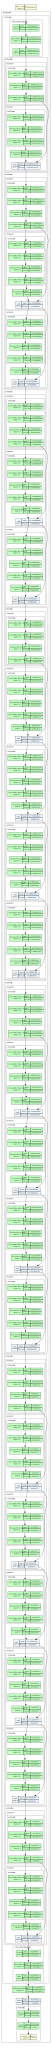

In [48]:
# Create transfer learning model
tl_model = EfficientNetB3TransferLearning(num_classes, DROPOUT_RATE, freeze_backbone=True).to(device)

# Display model summary
summary(tl_model, input_size=input_shape)
model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
model_graph.visual_graph

In [43]:
# Create transfer learning model
tl_model = MobileNetV3Small(num_classes, DROPOUT_RATE).to(device)

# Display model summary
summary(tl_model, input_size=input_shape)
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

TRANSFER LEARNING MODEL - Augmentation Strategy
Using: AutoAugment(IMAGENET) + RandomHorizontalFlip
Rationale: Matches ImageNet pretraining augmentation for better transfer learning

Dataset Validation:
  Train samples: 2112
  Val samples: 798
  ImageNet normalization: ENABLED
  Mean: [0.485, 0.456, 0.406]
  Std: [0.229, 0.224, 0.225]



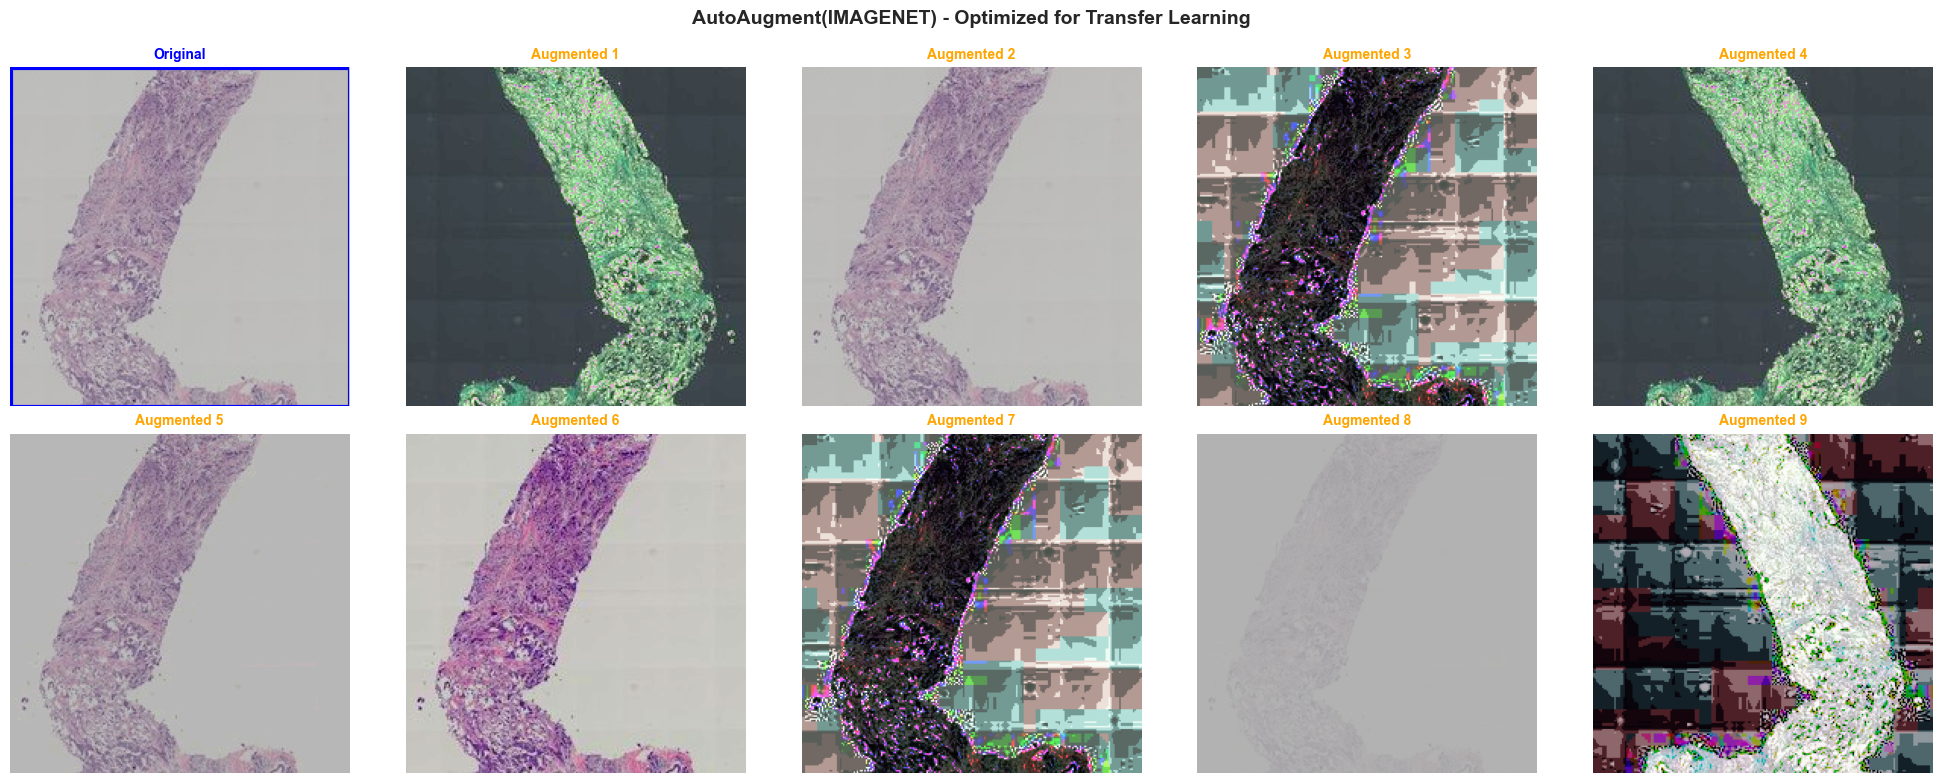


AUGMENTATION SUMMARY
✓ From Scratch:      TrivialAugmentWide (strongest)
✓ Transfer Learning: AutoAugment IMAGENET (pretrained-compatible)


In [49]:
# ============================================================
# TRANSFER LEARNING MODEL - Augmentation Strategy
# ============================================================

# For TRANSFER LEARNING: Use AutoAugment with ImageNet policy
train_augmentation_transfer = transforms.Compose([
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(p=0.5),
])

print("="*60)
print("TRANSFER LEARNING MODEL - Augmentation Strategy")
print("="*60)
print("Using: AutoAugment(IMAGENET) + RandomHorizontalFlip")
print("Rationale: Matches ImageNet pretraining augmentation for better transfer learning")
print()

# Create datasets with ImageNet-compatible augmentation and normalization
train_tl_ds = TissueDataset(X_train, y_train, augmentation=train_augmentation_transfer, normalize_imagenet=True)
val_tl_ds = TissueDataset(X_val, y_val, augmentation=None, normalize_imagenet=True)

train_tl_loader = make_loader(train_tl_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_tl_loader = make_loader(val_tl_ds, BATCH_SIZE, shuffle=False, drop_last=False)

print("Dataset Validation:")
print(f"  Train samples: {len(train_tl_ds)}")
print(f"  Val samples: {len(val_tl_ds)}")
print(f"  ImageNet normalization: ENABLED")
print(f"  Mean: {IMAGENET_MEAN}")
print(f"  Std: {IMAGENET_STD}")
print()

# Visualize augmentation effects (before normalization for visualization)
sample_img = X_train[0]
sample_tensor = torch.from_numpy(sample_img).permute(2, 0, 1)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    row = i // 5
    col = i % 5
    
    if i == 0:
        display_img = sample_img
        title = "Original"
        color = 'blue'
    else:
        aug_tensor = train_augmentation_transfer(sample_tensor.clone())
        display_img = aug_tensor.permute(1, 2, 0).numpy()
        title = f"Augmented {i}"
        color = 'orange'
    
    axes[row, col].imshow(np.clip(display_img, 0, 1))
    axes[row, col].set_title(title, fontsize=10, color=color, fontweight='bold')
    axes[row, col].axis('off')
    
    if i == 0:
        axes[row, col].add_patch(plt.Rectangle(
            (0, 0), display_img.shape[1], display_img.shape[0],
            fill=False, edgecolor=color, linewidth=3
        ))

plt.suptitle("AutoAugment(IMAGENET) - Optimized for Transfer Learning", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("AUGMENTATION SUMMARY")
print("="*60)
print("✓ From Scratch:      TrivialAugmentWide (strongest)")
print("✓ Transfer Learning: AutoAugment IMAGENET (pretrained-compatible)")
print("="*60)

In [50]:
# Setup training for transfer learning (without mixed precision)
experiment_name = "transfer_learning"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

# Create optimizer for transfer learning model
optimizer = torch.optim.RAdam(tl_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

print(f"Experiment: {experiment_name}")
print(f"Device: {device}")
print(f"Mixed precision: Disabled (scaler=None)")
print(f"Learning rate: {LEARNING_RATE}")

Experiment: transfer_learning
Device: cuda
Mixed precision: Disabled (scaler=None)
Learning rate: 0.0001


In [ ]:
# Train with transfer learning (no mixed precision scaler)
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_tl_loader,
    val_loader=val_tl_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=None,  # Disable mixed precision for transfer learning
    device=device,
    l2_lambda=L2_REGULARIZATION,
    writer=writer,
    scheduler=scheduler,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_f1 = round(max(tl_history['val_f1']) * 100, 2)
final_train_f1 = round(max(tl_history['train_f1']) * 100, 2)
print(f'\n{"="*60}')
print(f'Training Complete!')
print(f'Best Training F1: {final_train_f1}%')
print(f'Best Validation F1: {final_val_f1}%')
print(f'{"="*60}')

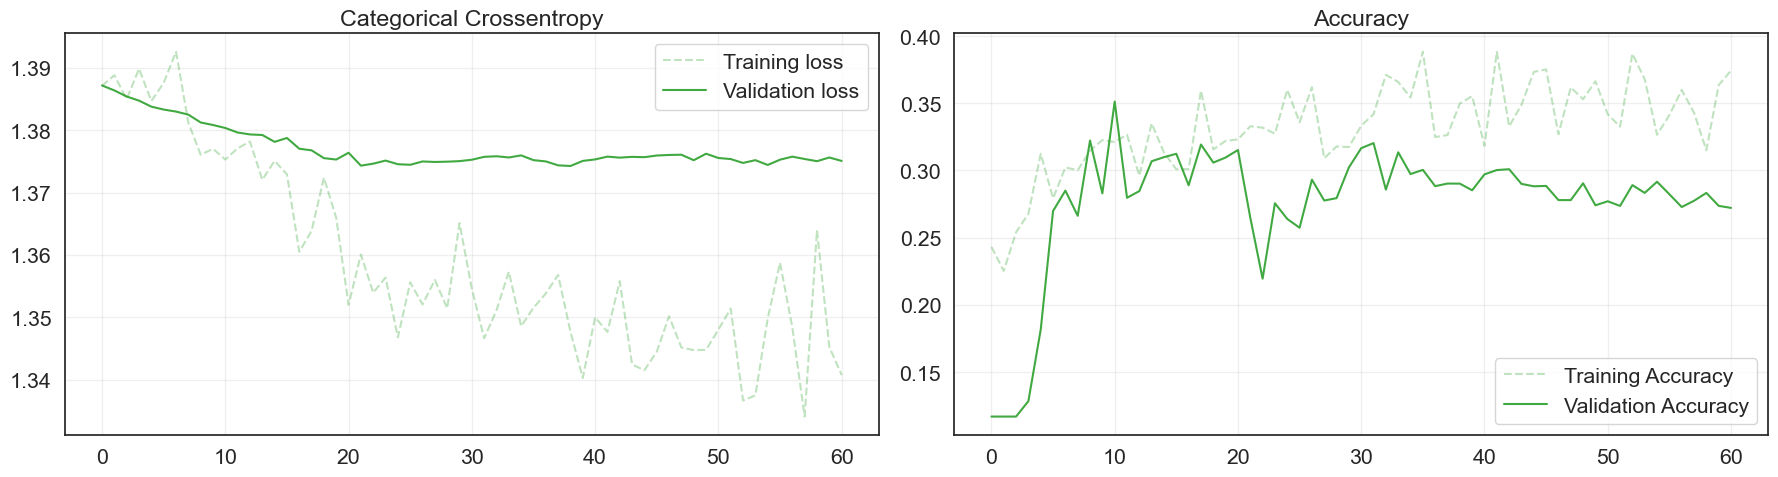

In [23]:
# Plot the results of the transfer learning training
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='#2ca02c', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color="#2ca02c")
ax1.set_title('Categorical Crossentropy') 
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(tl_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#2ca02c', linestyle='--')
ax2.plot(tl_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#2ca02c')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [24]:
# Make predictions on the test set created inside the training set
test_tl_ds = TissueDataset(X_test, y_test, augmentation=None, normalize_imagenet=True)
test_tl_loader = make_loader(test_tl_ds, BATCH_SIZE, shuffle=False, drop_last=False)

best_val_acc = max(tl_history['val_acc'])
model_path = Path(f"models/transfer_learning_best_model.pt")

if not model_path.exists():
    candidates = sorted(Path("models").glob(f"{experiment_name}_*_model.pt"))
    if candidates:
        model_path = candidates[-1]
    else:
        raise FileNotFoundError(f"No model file matching {model_path.name}")
    
tl_model.load_state_dict(torch.load(model_path, map_location=device))
tl_model.eval()

print(f"Loaded weights from {model_path.name}")

all_test_predictions = []
with torch.no_grad():
    for inputs, _ in test_tl_loader:
        inputs = inputs.to(device)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = tl_model(inputs)
        predictions = logits.argmax(dim=1)
        all_test_predictions.append(predictions.cpu().numpy())
all_test_predictions = np.concatenate(all_test_predictions)

# Calculate test metrics
test_f1 = f1_score(y_test, all_test_predictions, average='weighted')
test_precision = precision_score(y_test, all_test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(y_test, all_test_predictions, average='weighted', zero_division=0)

print(f"\nTest Set Performance:")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

Loaded weights from transfer_learning_best_model.pt

Test Set Performance:
F1 Score: 0.3909
Precision: 0.3667
Recall: 0.4286


## Fine tunining

In [25]:
# Load the transfer learning model
ft_model = MobileNetV3Small(num_classes, DROPOUT_RATE).to(device)
ft_model.load_state_dict(torch.load("models/transfer_learning_best_model.pt"))

# Unfreeze the last N layers of the backbone
N_LAYERS_TO_UNFREEZE = 20

# Strategy: Freeze everything first, then unfreeze the last few blocks
for param in ft_model.parameters():
    param.requires_grad = False

# The classifier is always trainable
for param in ft_model.backbone.classifier.parameters():
    param.requires_grad = True

# Unfreeze the last 2 blocks of the feature extractor (EfficientNet-B0 has 9 blocks usually)
# Adjust slice index [-2:] to unfreeze more or fewer layers
for block in ft_model.backbone.features[-2:]:
    for param in block.parameters():
        param.requires_grad = True

# Check trainable parameters
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in ft_model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")

Trainable parameters: 679,060 / 1,255,524


In [47]:
# Reuse datasets from transfer learning (with ImageNet normalization)
train_ft_ds = TissueDataset(X_train, y_train, augmentation=train_augmentation_transfer, normalize_imagenet=True)
val_ft_ds = TissueDataset(X_val, y_val, augmentation=None, normalize_imagenet=True)

train_ft_loader = make_loader(train_ft_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_ft_loader = make_loader(val_ft_ds, BATCH_SIZE, shuffle=False, drop_last=False)

In [48]:
# Setup Training (Lower learning rate for Fine-Tuning)
experiment_name = "fine_tuning"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
optimizer = torch.optim.Adam(ft_model.parameters(), lr=1e-4) # 10x smaller LR
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [49]:
%%time
# Fine-tune the model
ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_ft_loader,
    val_loader=val_ft_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_acc = round(max(ft_history['val_acc']) * 100, 2)
print(f'Final validation accuracy: {final_val_acc}%')

Training 200 epochs...
Epoch   5/200 | Train: Loss=1.3710, F1=0.2938, Prec=0.3309, Rec=0.3313 | Val: Loss=1.3787, F1=0.2602, Prec=0.2821, Rec=0.2995
Epoch  10/200 | Train: Loss=1.3590, F1=0.3153, Prec=0.3588, Rec=0.3064 | Val: Loss=1.3779, F1=0.2192, Prec=0.2522, Rec=0.2299
Epoch  15/200 | Train: Loss=1.3194, F1=0.3265, Prec=0.3647, Rec=0.3271 | Val: Loss=1.3861, F1=0.2376, Prec=0.3070, Rec=0.2406
Epoch  20/200 | Train: Loss=1.2758, F1=0.3676, Prec=0.4289, Rec=0.3747 | Val: Loss=1.4125, F1=0.1852, Prec=0.2561, Rec=0.2139
Epoch  25/200 | Train: Loss=1.2019, F1=0.4191, Prec=0.4553, Rec=0.4224 | Val: Loss=1.4317, F1=0.2412, Prec=0.2795, Rec=0.2406
Epoch  30/200 | Train: Loss=1.1754, F1=0.4029, Prec=0.4375, Rec=0.4079 | Val: Loss=1.4867, F1=0.2444, Prec=0.3032, Rec=0.2513
Epoch  35/200 | Train: Loss=1.1487, F1=0.4525, Prec=0.4621, Rec=0.4576 | Val: Loss=1.5118, F1=0.2924, Prec=0.3035, Rec=0.2888
Epoch  40/200 | Train: Loss=1.0807, F1=0.4691, Prec=0.4830, Rec=0.4741 | Val: Loss=1.5397, F1=0

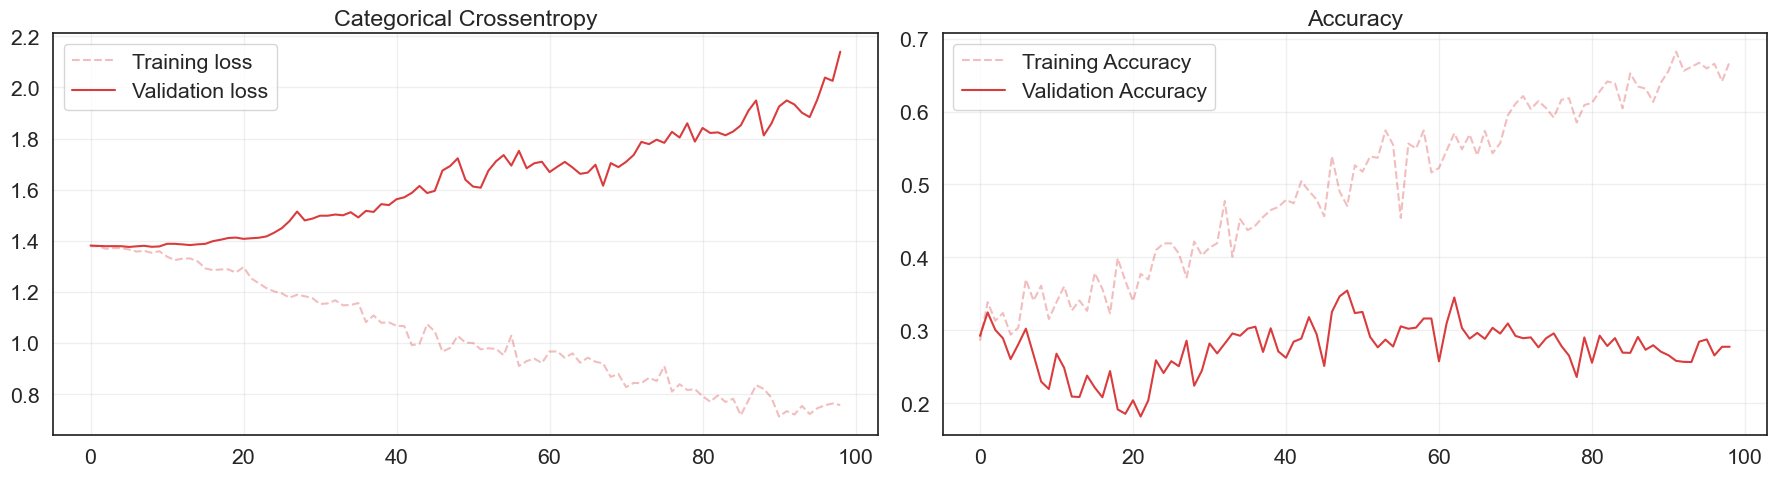

In [50]:
# Plot the results of fine-tuning
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
# Plot of training and validation loss on the first axis
ax1.plot(ft_history['train_loss'], label='Training loss', alpha=0.3, color='#d62728', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Validation loss', alpha=0.9, color="#d62728")
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(ft_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#d62728', linestyle='--')
ax2.plot(ft_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#d62728')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# **CAM**

In [18]:
from concurrent.futures import ThreadPoolExecutor

In [19]:
filtered_patched_data_dir = datasets_path / "filtered_patched_data"

# Get all patch files
random.seed(42)
all_patch_files = list(filtered_patched_data_dir.glob("*.png"))

if len(all_patch_files) == 0:
    raise FileNotFoundError(f"No patch files found in {filtered_patched_data_dir}")

# Sample ONLY 1 random patch
random_image = random.choice(all_patch_files)
random_images = [random_image]  # Put it in a list to keep compatibility with existing code

IMG_SIZE = 224

print(f"✓ Selected 1 random patch for CAM")
print(f"Selected file: {random_image.name}")

✓ Selected 1 random patch for CAM
Selected file: patch_02619_img_0590.png


In [20]:
def load_images_from_folder(folder, img_dim):
    """
    Load images from folder and preprocess them.

    Args:
        folder: Path to folder containing images
        img_dim: Target dimension for square images

    Returns:
        Numpy array of preprocessed images
    """
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename))
        if img is None:
            continue

        # Centre crop to make image square
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2,
                  (img.shape[1]-dim)//2:(img.shape[1]+dim)//2]

        # Resize to fixed size
        img = cv2.resize(img, (img_dim, img_dim))

        # Convert from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        images.append(img)

    return np.array(images)


def preprocess_dataset(image_dir='cats_dogs_images', image_size=(244, 244)):
    """
    Preprocess dataset with bounding box annotations.

    Args:
        image_dir: Directory containing images
        image_size: Target image size (width, height)

    Returns:
        Tuple of (labels, bounding_boxes, images)
    """
    df = pd.read_csv('cats_dogs_images_boxes.csv')

    def process_row(row):
        """Process a single row from the CSV file."""
        img_path = row[0]
        label = int(row[3])
        bbox_coords = list(map(float, row[4:8]))

        # Load image
        img = cv2.imread(os.path.join(image_dir, img_path))
        if img is None:
            return None

        # Get original dimensions
        orig_h, orig_w = img.shape[:2]
        x1, y1, x2, y2 = bbox_coords

        # Normalise bounding box coordinates to [0, 1]
        bbox = [x1/orig_w, y1/orig_h, x2/orig_w, y2/orig_h]

        # Resize image and convert colour space
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return label, bbox, img

    # Process all rows in parallel
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(process_row, df.itertuples(index=False)))

    # Filter out None results and separate components
    results = [r for r in results if r is not None]
    labels, boxes, img_list = zip(*results)

    return np.array(list(labels)), np.array(list(boxes)), np.array(list(img_list))


print("Data loading functions defined.")

Data loading functions defined.


In [21]:
# Clear GPU memory first
import gc
torch.cuda.empty_cache()
gc.collect()

# Prepare test data transformations
transform_test = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Load ONLY the single selected image (not entire folder!)
print(f"Loading single image: {random_image.name}")
img = cv2.imread(str(random_image))
if img is None:
    raise FileNotFoundError(f"Could not load {random_image}")

# Preprocess image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

# Store as array for compatibility with visualization code
X_test_raw = np.array([img])  # Single image in array

# Apply transformations to SINGLE image
X_test_tensor = torch.stack([
    transform_test(Image.fromarray(img)) for img in X_test_raw
]).to(device)

print(f"✓ Loaded {X_test_tensor.shape[0]} image(s)")
print(f"  Shape: {X_test_tensor.shape}")
print(f"  GPU Memory: {torch.cuda.memory_allocated()/1024**2:.2f} MB / {torch.cuda.memory_reserved()/1024**2:.2f} MB")

In [22]:
label_names = [
    "Luminal A",
    "Luminal B",
    "HER2(+)",
    "Triple Negative"
]

num_to_labels = {i: label for i, label in enumerate(label_names)}

In [27]:
# @title 👁️ **Visualise CAM**
def visualize_cam(model, images_tensor, original_images, target_class=None, num_to_labels=None):
    """
    Visualise Class Activation Maps (CAM).

    CAM highlights the regions that are most important for classification.

    Args:
        model: Trained classifier
        images_tensor: Preprocessed images tensor
        original_images: Original images for visualisation
        target_class: Optional specific class to visualise (if None, uses predicted class)
    """
    model.eval()

    # Hook the last feature layer
    target_layer = model.backbone.features[-1]
    activations = []

    def hook_fn(module, input, output):
        """Save activations from forward pass."""
        activations.append(output)

    # Register forward hook
    handle = target_layer.register_forward_hook(hook_fn)

    # Get weights from final linear layer
    fc_weights = model.backbone.classifier[1].weight.data.cpu().numpy()

    # Generate predictions
    with torch.no_grad():
        outputs = model(images_tensor)
        preds = outputs.argmax(dim=1).cpu().numpy()

    # Remove hook
    handle.remove()

    # Get activations
    acts = activations[0].cpu().numpy()

    # Visualise CAMs - Modified logic based on input length
    num_total_imgs = len(images_tensor)

    if num_total_imgs == 10:
        num_rows = 2
        num_cols = 5
        plot_count = 10
        figsize = (20, 9)
    else:
        num_rows = 1
        num_cols = 5 # Always create 5 columns for the "otherwise" case
        plot_count = min(5, num_total_imgs) # Plot only up to 5 images
        figsize = (20, 4)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Ensure axes is always a 1D iterable array for consistent access
    if num_rows * num_cols == 1:
        axes = np.array([axes]) # Make it an array of one element
    else:
        axes = axes.flatten()


    title_suffix = f"Class: {num_to_labels[target_class]}" if target_class is not None else "Predicted Class"
    plt.suptitle(f'Class Activation Maps - {title_suffix}',
                fontsize=18, fontweight='bold')

    for i in range(plot_count):
        ax = axes[i] # Use flattened axes for consistent access

        # Use target class or predicted class
        c_idx = target_class if target_class is not None else preds[i]

        # Compute weighted CAM
        cam = np.zeros(acts.shape[2:], dtype=np.float32)
        for w, feat in zip(fc_weights[c_idx], acts[i]):
            cam += w * feat

        # Resize and normalise
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = np.maximum(cam, 0)  # ReLU activation
        cam = cam / (cam.max() + 1e-8)

        # Display original image with CAM overlay
        ax.imshow(original_images[i])
        ax.imshow(cam, cmap='turbo', alpha=0.5)
        ax.axis('off')
        ax.set_title(f"{num_to_labels[c_idx]}", fontsize=13, fontweight='bold')

    # Hide any unused subplots
    for j in range(plot_count, num_rows * num_cols):
        if j < len(axes): # Check if the axis exists before trying to hide it
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
# Generate CAMs for predicted classes (single image)
print("Generating Class Activation Map for single image...")

img_tensor = X_test_tensor[0].unsqueeze(0)   # shape [1, C, H, W]
img_raw = X_test_raw[0]

visualize_cam(tl_model, img_tensor, [img_raw], target_class=None, num_to_labels=num_to_labels)

# Show actual vs predicted
with torch.no_grad():
    output = tl_model(img_tensor)
    pred_class = output.argmax(dim=1).item()
    pred_prob = torch.softmax(output, dim=1)[0, pred_class].item()

print(f"\n{'='*60}")
print(f"Prediction Results:")
print(f"{'='*60}")
print(f"Image: {random_image.name}")
print(f"Predicted class: {num_to_labels[pred_class]}")
print(f"Confidence: {pred_prob*100:.2f}%")
print(f"{'='*60}")